## 1. Importing Libraries and Configuring Variables

In [1]:
!pip install numpy pillow matplotlib torch torchvision

import os, random, math, glob
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
class Cfg:
    DATA_ROOT = 'CT Scans'   # folder containing Healthy/ and Tumor/
    CLASS_NAMES = ['Healthy', 'Tumor']
    IMG_SIZE = (256, 256)
    BATCH_SIZE = 32
    EPOCHS = 20
    LR = 1e-3
    WEIGHT_DECAY = 1e-4
    SPLIT = (0.70, 0.15, 0.15)  # train, val, test fractions
    OUT_DIR = 'outputs_ct_cls'
    N_GRADCAM_SAVE = 12  # number of test images to save Grad-CAM overlays for

cfg = Cfg()
os.makedirs(cfg.OUT_DIR, exist_ok=True)

## 2. Exploring and Splitting the Dataset

In [3]:
def list_images(folder):
    exts = ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG')
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

all_paths = []
all_labels = []
for idx, cname in enumerate(cfg.CLASS_NAMES):
    cdir = os.path.join(cfg.DATA_ROOT, cname)
    paths = list_images(cdir)
    labels = [idx]*len(paths)
    all_paths.extend(paths)
    all_labels.extend(labels)

if len(all_paths) == 0:
    raise FileNotFoundError(f"No images found under {cfg.DATA_ROOT}/Healthy or {cfg.DATA_ROOT}/Tumor")

idxs = list(range(len(all_paths)))
random.shuffle(idxs)
all_paths = [all_paths[i] for i in idxs]
all_labels = [all_labels[i] for i in idxs]

n = len(all_paths)
n_train = int(cfg.SPLIT[0]*n)
n_val = int(cfg.SPLIT[1]*n)
n_test = n - n_train - n_val

train_paths = all_paths[:n_train]
train_labels = all_labels[:n_train]
val_paths   = all_paths[n_train:n_train+n_val]
val_labels  = all_labels[n_train:n_train+n_val]
test_paths  = all_paths[n_train+n_val:]
test_labels = all_labels[n_train+n_val:]

len(train_paths), len(val_paths), len(test_paths)

(3232, 692, 694)

In [4]:
class CTClassDataset(Dataset):
    def __init__(self, paths, labels, augment=False, img_size=(256,256)):
        self.paths = paths
        self.labels = labels
        self.augment = augment
        self.img_size = img_size
        if augment:
            self.tf = transforms.Compose([
                transforms.Resize(img_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
            ])
        else:
            self.tf = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
            ])

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = self.labels[idx]
        img = Image.open(p).convert('L')
        x = self.tf(img)
        return x, y

train_ds = CTClassDataset(train_paths, train_labels, augment=True, img_size=cfg.IMG_SIZE)
val_ds = CTClassDataset(val_paths, val_labels, augment=False, img_size=cfg.IMG_SIZE)
test_ds = CTClassDataset(test_paths, test_labels, augment=False, img_size=cfg.IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(3232, 692, 694)

## 3. Training the CNN model

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    def forward(self, x): return self.conv(x)

class CTClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.block1 = ConvBlock(1, 32)
        self.block2 = ConvBlock(32, 64)
        self.block3 = ConvBlock(64, 128)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, n_classes)
        self._gradcam_acts = None
        self._gradcam_grads = None
        self.block3.conv[0].register_forward_hook(self._save_acts)
        self.block3.conv[0].register_backward_hook(self._save_grads)

    def _save_acts(self, module, inp, out):
        self._gradcam_acts = out.detach()
    def _save_grads(self, module, grad_in, grad_out):
        self._gradcam_grads = grad_out[0].detach()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x).flatten(1)
        logits = self.fc(x)
        return logits

model = CTClassifier(n_classes=2).to(device)
sum(p.numel() for p in model.parameters())/1e6

0.287586

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.numel()
    return correct/total

history = {"train_loss":[], "train_acc":[], "val_acc":[]}
best_val_acc = 0.0
ckpt_path = 'outputs_ct_cls/ct_cls_best.pth'

In [7]:
# === Training Loop ===
for epoch in range(1, 21):
    model.train()
    run_loss, run_acc, n_batches = 0.0, 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), torch.tensor(yb, dtype=torch.long, device=device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        run_acc += accuracy_from_logits(logits, yb)
        n_batches += 1
    train_loss = run_loss/max(1,n_batches)
    train_acc  = run_acc/max(1,n_batches)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    model.eval()
    val_accs = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), torch.tensor(yb, dtype=torch.long, device=device)
            logits = model(xb)
            val_accs.append(accuracy_from_logits(logits, yb))
    val_acc = float(np.mean(val_accs)) if val_accs else 0.0
    history['val_acc'].append(val_acc)

    scheduler.step(val_acc)
    print(f"Epoch {epoch:02d}/20 | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('outputs_ct_cls', exist_ok=True)
        torch.save({'model': model.state_dict(), 'epoch': epoch, 'val_acc': val_acc}, ckpt_path)
        print('  -> Saved best:', ckpt_path)

/Users/pranav/Python/Neuroflux CT/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/fs/b3vl689x50z_mlnttjx59j840000gn/T/ipykernel_29163/2163901382.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb, dtype=torch.long, device=device)
/Users/pranav/Python/Neuroflux CT/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_ba

Epoch 01/20 | train_loss=0.3519 | train_acc=0.8586 | val_acc=0.9187
  -> Saved best: outputs_ct_cls/ct_cls_best.pth
Epoch 02/20 | train_loss=0.2797 | train_acc=0.9016 | val_acc=0.5412
Epoch 03/20 | train_loss=0.2711 | train_acc=0.9053 | val_acc=0.4872
Epoch 04/20 | train_loss=0.2145 | train_acc=0.9332 | val_acc=0.4844
Epoch 05/20 | train_loss=0.2202 | train_acc=0.9301 | val_acc=0.4830
Epoch 06/20 | train_loss=0.1788 | train_acc=0.9409 | val_acc=0.9372
  -> Saved best: outputs_ct_cls/ct_cls_best.pth
Epoch 07/20 | train_loss=0.1701 | train_acc=0.9409 | val_acc=0.9514
  -> Saved best: outputs_ct_cls/ct_cls_best.pth
Epoch 08/20 | train_loss=0.1638 | train_acc=0.9449 | val_acc=0.9344
Epoch 09/20 | train_loss=0.1484 | train_acc=0.9489 | val_acc=0.9565
  -> Saved best: outputs_ct_cls/ct_cls_best.pth
Epoch 10/20 | train_loss=0.1378 | train_acc=0.9536 | val_acc=0.9486
Epoch 11/20 | train_loss=0.1415 | train_acc=0.9542 | val_acc=0.9509
Epoch 12/20 | train_loss=0.1536 | train_acc=0.9502 | val_acc

## 4. Plot the Training Curves

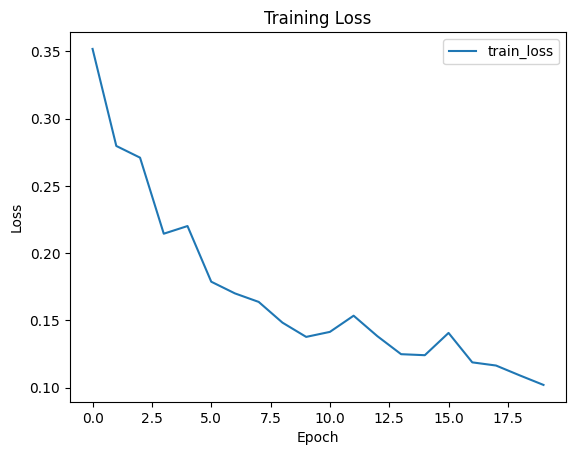

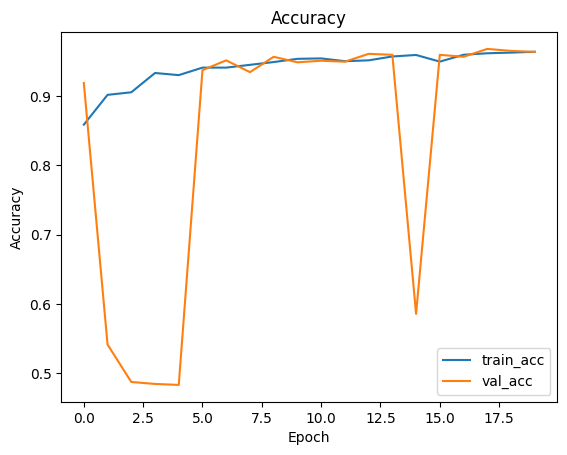

In [8]:
plt.figure()
plt.plot(history['train_loss'], label='train_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss'); plt.legend()
plt.show()

plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()
plt.show()

## 5. Evaluate the Accuracy

Loaded best checkpoint @ epoch 18 val_acc 0.9678977272727273
Test Accuracy: 0.9769452449567724


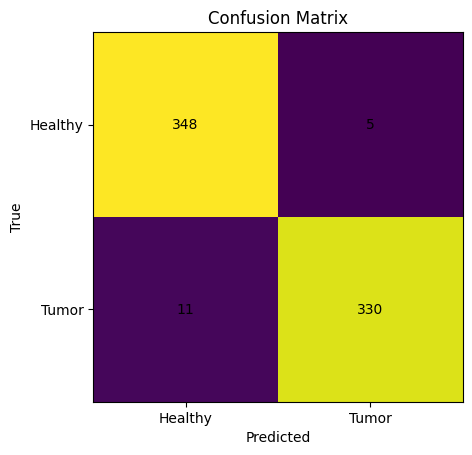

In [9]:
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model'])
    print('Loaded best checkpoint @ epoch', ckpt['epoch'], 'val_acc', ckpt['val_acc'])
else:
    print('Warning: best checkpoint not found, using current model.')

model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_trues.extend(yb)

all_trues = np.array(all_trues)
all_preds = np.array(all_preds)
test_acc = (all_trues == all_preds).mean() if len(all_trues)>0 else 0.0
print('Test Accuracy:', float(test_acc))

cm = np.zeros((2,2), dtype=int)
for t,p in zip(all_trues, all_preds):
    cm[int(t), int(p)] += 1

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks([0,1], ['Healthy','Tumor'])
plt.yticks([0,1], ['Healthy','Tumor'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

## 6. Grad-CAM Implementation

/Users/pranav/Python/Neuroflux CT/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/pranav/Python/Neuroflux CT/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


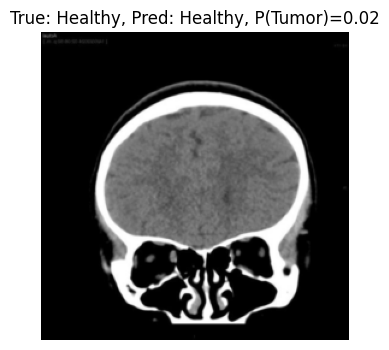

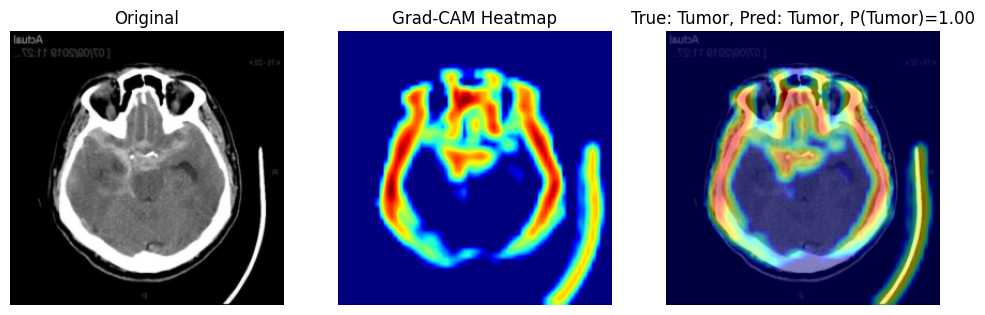

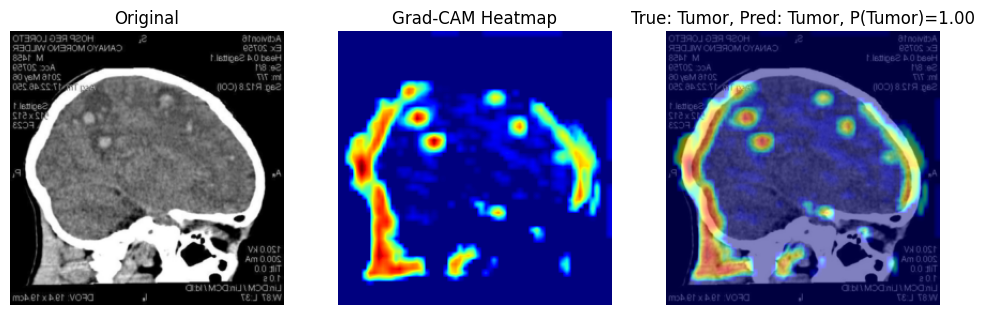

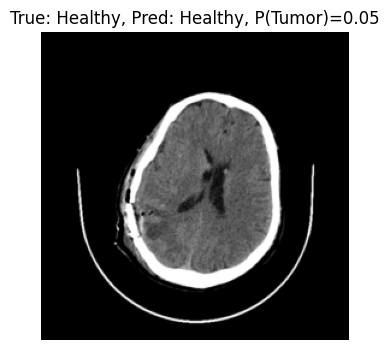

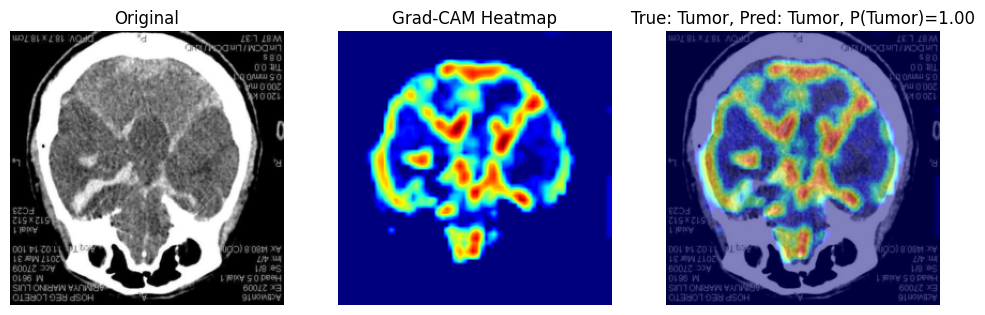

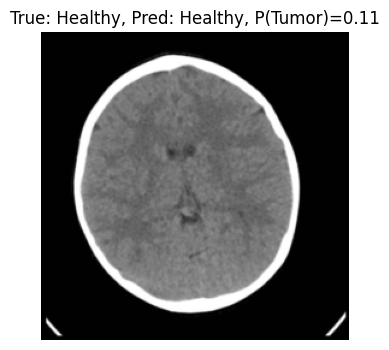

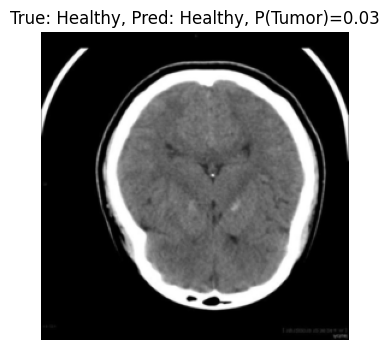

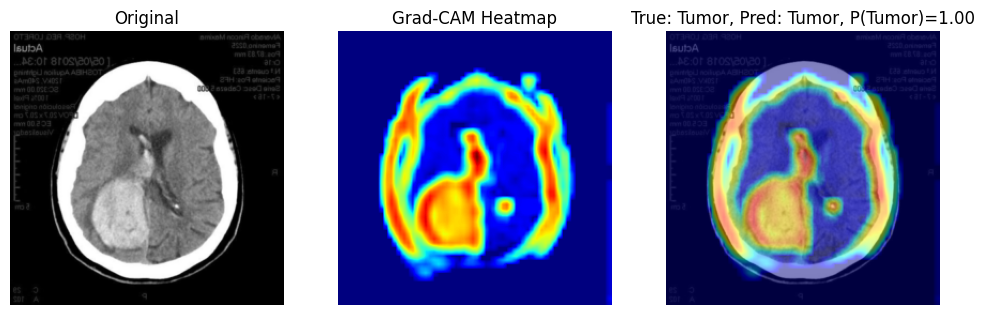

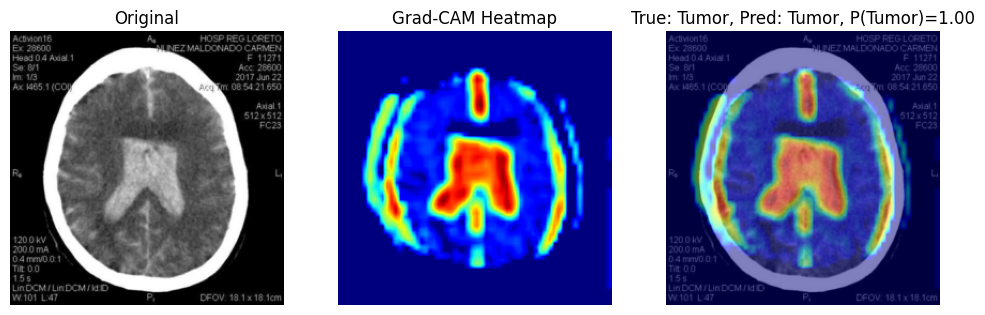

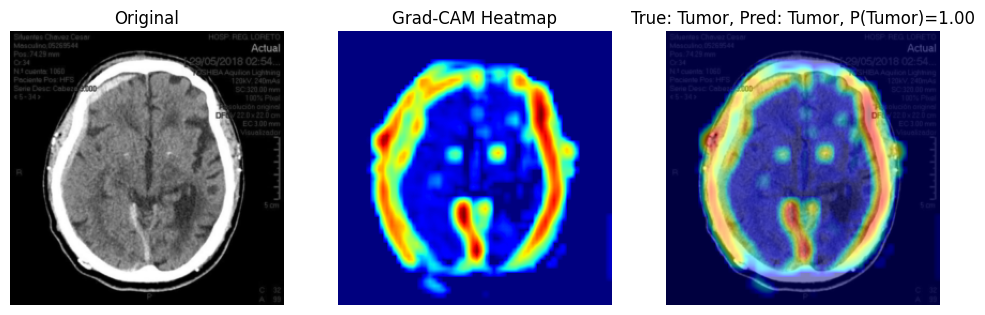

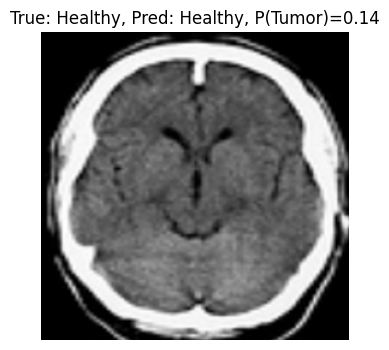

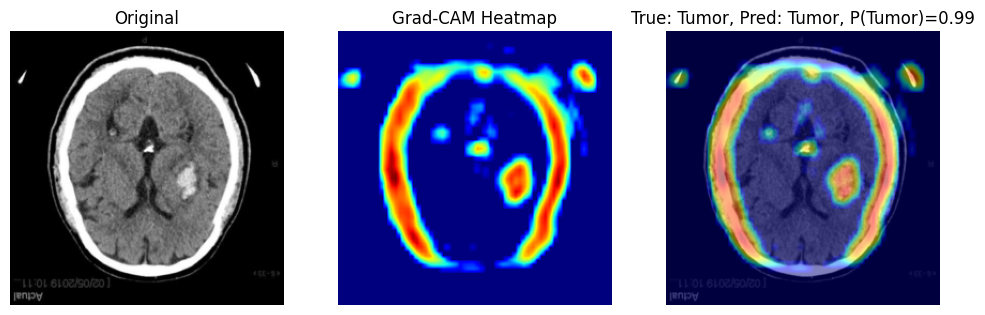

Saved 12 visualizations to outputs_ct_cls/gradcam_examples


In [10]:
def gradcam_for_batch(model, xb, target_class=None):
    model.eval()
    xb = xb.to(device).requires_grad_(True)
    logits = model(xb)
    if target_class is None:
        target = torch.argmax(logits, dim=1)
    else:
        target = torch.full((xb.size(0),), int(target_class), dtype=torch.long, device=device)
    sel = logits[torch.arange(xb.size(0)), target]
    model.zero_grad()
    sel.sum().backward(retain_graph=True)
    acts = model._gradcam_acts
    grads = model._gradcam_grads
    weights = grads.mean(dim=(2,3), keepdim=True)
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cams = []
    for i in range(cam.size(0)):
        c = cam[i,0]
        c = c - c.min()
        denom = (c.max() - c.min()).clamp(min=1e-6)
        c = c/denom
        cams.append(c.unsqueeze(0))
    cam = torch.stack(cams, dim=0)
    cam = F.interpolate(cam, size=xb.shape[-2:], mode='bilinear', align_corners=False)
    probs = torch.softmax(logits, dim=1)
    return cam.detach().cpu(), target.detach().cpu(), probs.detach().cpu()

gradcam_dir = 'outputs_ct_cls/gradcam_examples'
os.makedirs(gradcam_dir, exist_ok=True)

saved = 0
for xb, yb in test_loader:
    cam, tgt, probs = gradcam_for_batch(model, xb)
    xb_cpu = xb.cpu()
    preds = probs.argmax(dim=1)
    for i in range(xb_cpu.size(0)):
        img = xb_cpu[i,0].detach().numpy()
        pred_class = int(preds[i])
        true_class = int(yb[i])

        if pred_class == 1:
            hm  = cam[i,0].detach().numpy()

            hm = hm ** 0.5
            hm = hm / hm.max()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))

            axs[0].imshow(img, cmap='gray')
            axs[0].set_title("Original")
            axs[0].axis('off')

            axs[1].imshow(hm, cmap='jet')
            axs[1].set_title("Grad-CAM Heatmap")
            axs[1].axis('off')

            axs[2].imshow(img, cmap='gray')
            axs[2].imshow(hm, cmap='jet', alpha=0.5)
            title = f"True: {'Healthy' if true_class==0 else 'Tumor'}, Pred: Tumor, P(Tumor)={probs[i,1].item():.2f}"
            axs[2].set_title(title)
            axs[2].axis('off')

        else:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(img, cmap='gray')
            title = f"True: {'Healthy' if true_class==0 else 'Tumor'}, Pred: Healthy, P(Tumor)={probs[i,1].item():.2f}"
            ax.set_title(title)
            ax.axis('off')

        out_path = os.path.join(gradcam_dir, f'gradcam_{saved:03d}.png')
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        saved += 1
        if saved >= 12:
            break
    if saved >= 12:
        break

print(f"Saved {saved} visualizations to {gradcam_dir}")